# BIOSI 2020/21 FYP Allocation

In [1]:
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matching.games import StudentAllocation

warnings.filterwarnings("ignore")

## reading and cleaning

In [2]:
students = pd.read_excel("data/students.xlsx", na_values=["nan"])
projects = pd.read_excel("data/projects.xlsx")
supervisors = pd.read_excel("data/supervisors.xlsx")

In [3]:
students = students.fillna(value="NaN")

for i in range(1, 26):
    students[i] = students[i].astype(str).str.replace(u"\xa0", "").str.strip()
    
students = students.replace(
    {"AWDLT2": "ADWLT2", "BDGPL2": "BDGPL1", "DJMT3": "DJMLT3",
     "EB1LT2": "EY1LT1", "HQILT1": "HQ1LT1", "IMGPL7": "IMGPL1",
     "IPVPD": "IPVPD1", "M1LT1": "JM1LT1", "NAXPB2": "NAKPB2"}
)

In [4]:
projects["Staff Name"] = projects["Staff Name"].str.upper()

In [5]:
supervisors["Name"] = supervisors["Name"].str.upper()

## dictionaries

In [6]:
student_preferences = {
    student: [project for project in prefs if project != "NaN"]
    for _, (student, *prefs) in students.drop("Ranking", axis=1).iterrows()
}

In [7]:
project_capacities = {
    project: capacity
    for _, (project, capacity) in projects[["Project Code", "Capacity"]].iterrows()
}
project_supervisors = {
    project: supervisor
    for _, (project, supervisor) in projects[["Project Code", "Staff Name"]].iterrows()
}

In [8]:
supervisor_capacities = {
    supervisor: capacity for _, (supervisor, capacity) in supervisors.iterrows()
}
supervisor_preferences = {
    supervisor: students["Student Number"].tolist()
    for supervisor in supervisors["Name"]
}

## the game

In [9]:
game = StudentAllocation.create_from_dictionaries(
    student_preferences,
    supervisor_preferences,
    project_supervisors,
    project_capacities,
    supervisor_capacities,
    clean=True,
)

In [10]:
ranked_projects = {
    project.name for student in game.students for project in student.prefs
}

unranked_projects = set(projects["Project Code"]).difference(ranked_projects)

In [11]:
unranked_projects

set()

In [12]:
ranked_supervisors = {
    project.supervisor.name
    for student in game.students for project in student.prefs
}

unranked_supervisors = set(supervisors["Name"]).difference(ranked_supervisors)

In [13]:
unranked_supervisors

set()

In [14]:
matching = game.solve()

## supervisor utilisation

In [15]:
supervisor_free_spaces = {
    supervisor: supervisor.capacity - len(supervisor.matching)
    for supervisor in game.supervisors
}

supervisor_utilisation = {
    supervisor: len(supervisor.matching) / supervisor.capacity
    for supervisor in game.supervisors
}

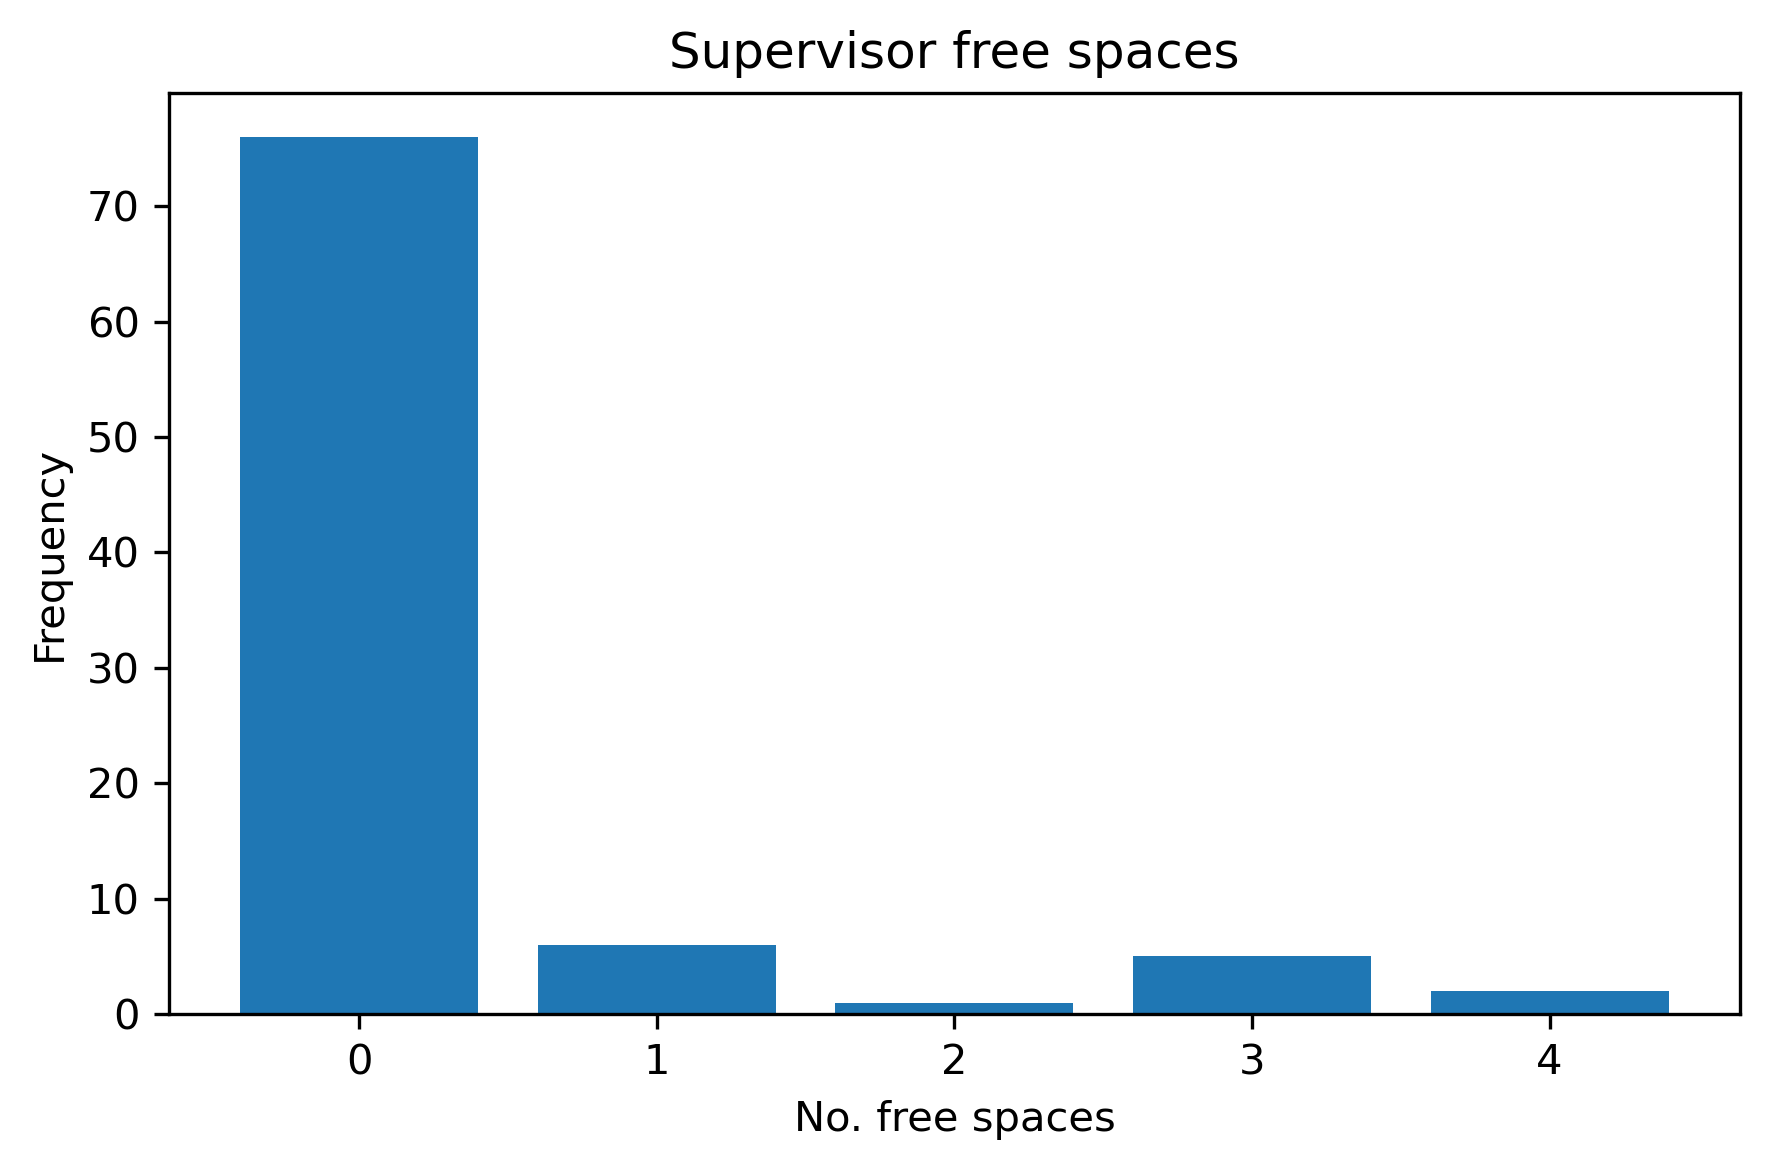

In [16]:
_, ax = plt.subplots(dpi=300)

data = Counter(supervisor_free_spaces.values())
ax.bar(data.keys(), data.values())

ax.set(
    xlabel="No. free spaces",
    ylabel="Frequency",
    xticks=range(max(data.keys()) + 1),
    title="Supervisor free spaces",
)

plt.tight_layout()
plt.savefig("img/supervisor_free_spaces.pdf", transparent=True)

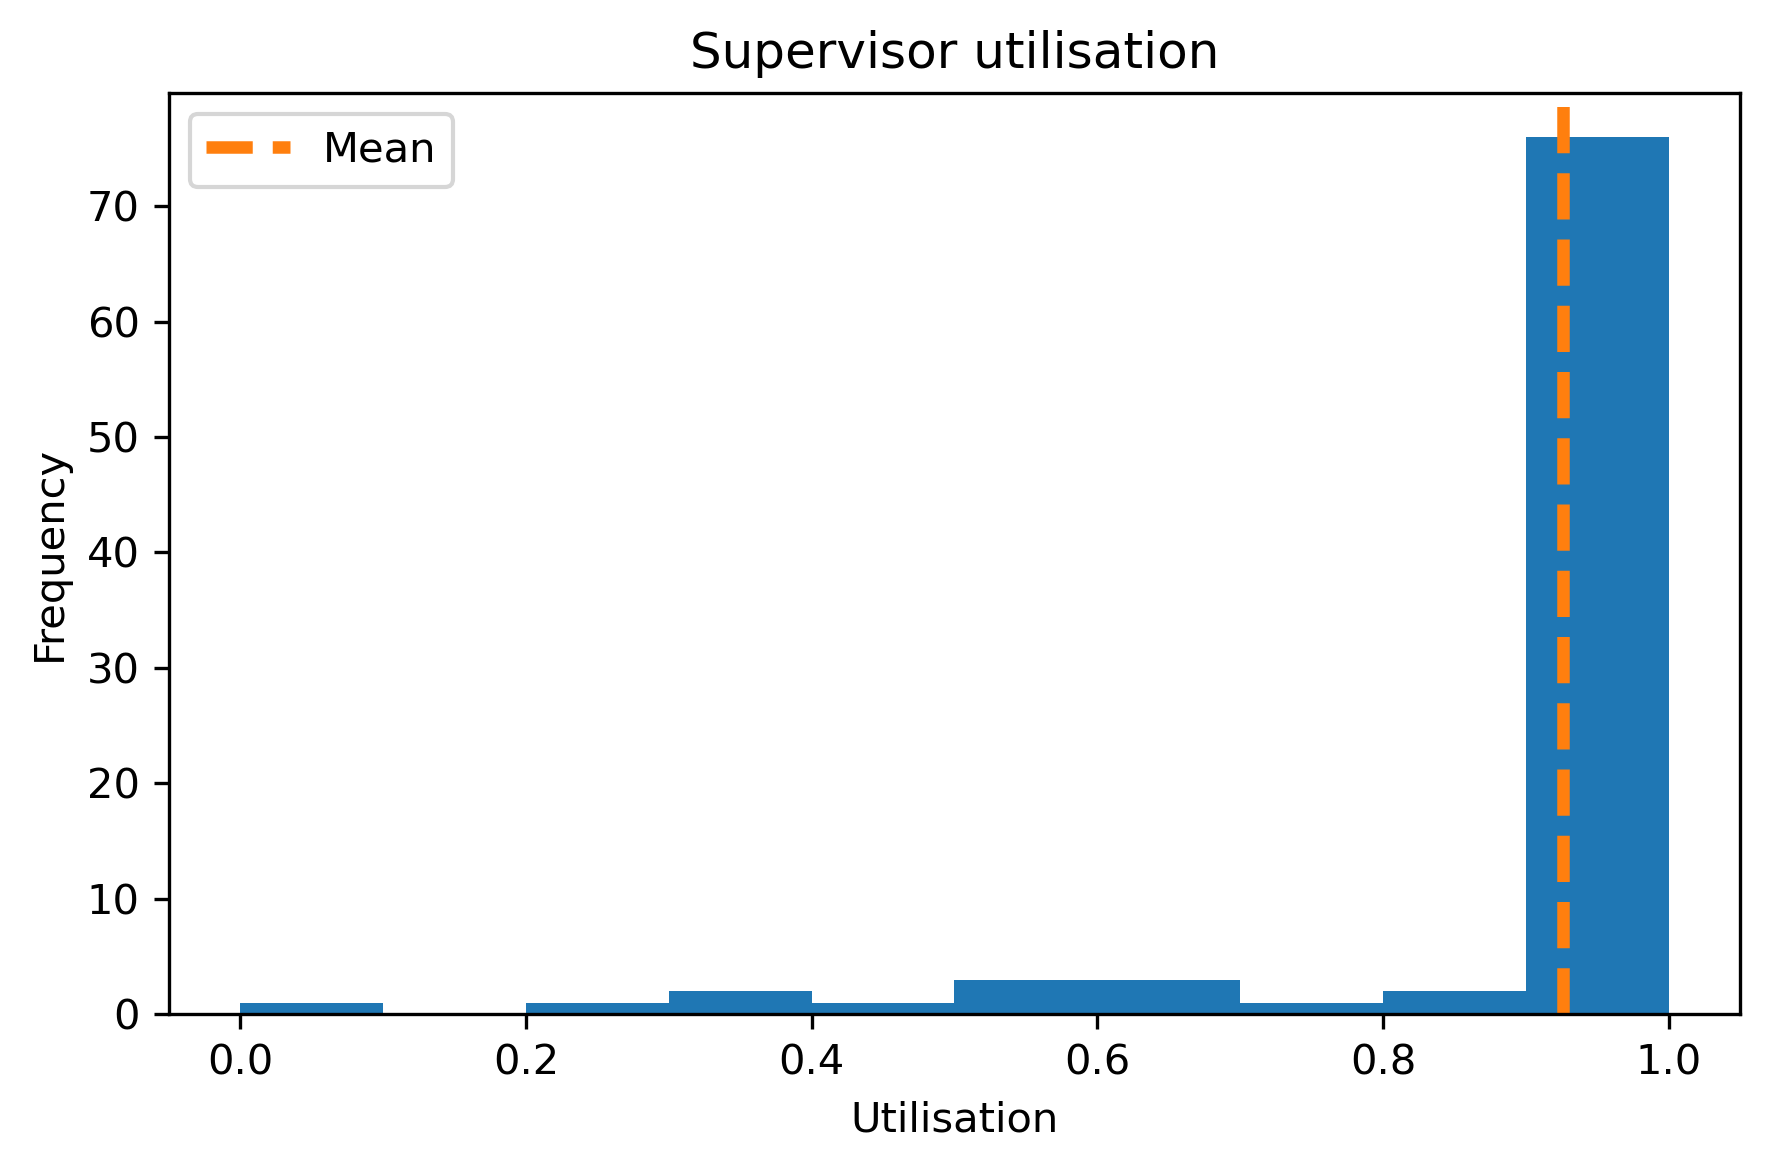

In [17]:
_, ax = plt.subplots(dpi=300)

values = list(supervisor_utilisation.values())
ax.hist(values)

ylims = ax.get_ylim()
ax.vlines(
    np.mean(values), *ylims, "tab:orange", linestyle="dashed", label="Mean", lw=3
)

ax.set(
    ylim=ylims,
    xlabel="Utilisation",
    ylabel="Frequency",
    title="Supervisor utilisation",
)

ax.legend()

plt.tight_layout()
plt.savefig("img/supervisor_utilisation.pdf", transparent=True)

In [18]:
supervisor_df = pd.concat(
    (pd.Series(supervisor_free_spaces), pd.Series(supervisor_utilisation)), axis=1
)
supervisor_df.columns = ["free_spaces", "utilisation"]
supervisor_df.describe().iloc[1:, :]

,free_spaces,utilisation
mean,0.344444,0.925926
std,0.926042,0.196284
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,4.000000,1.000000


## project utilisation

In [19]:
project_free_spaces = {
    project: project.capacity - len(project.matching)
    for project in game.projects
}

project_utilisation = {
    project: len(project.matching) / project.capacity
    for project in game.projects
}

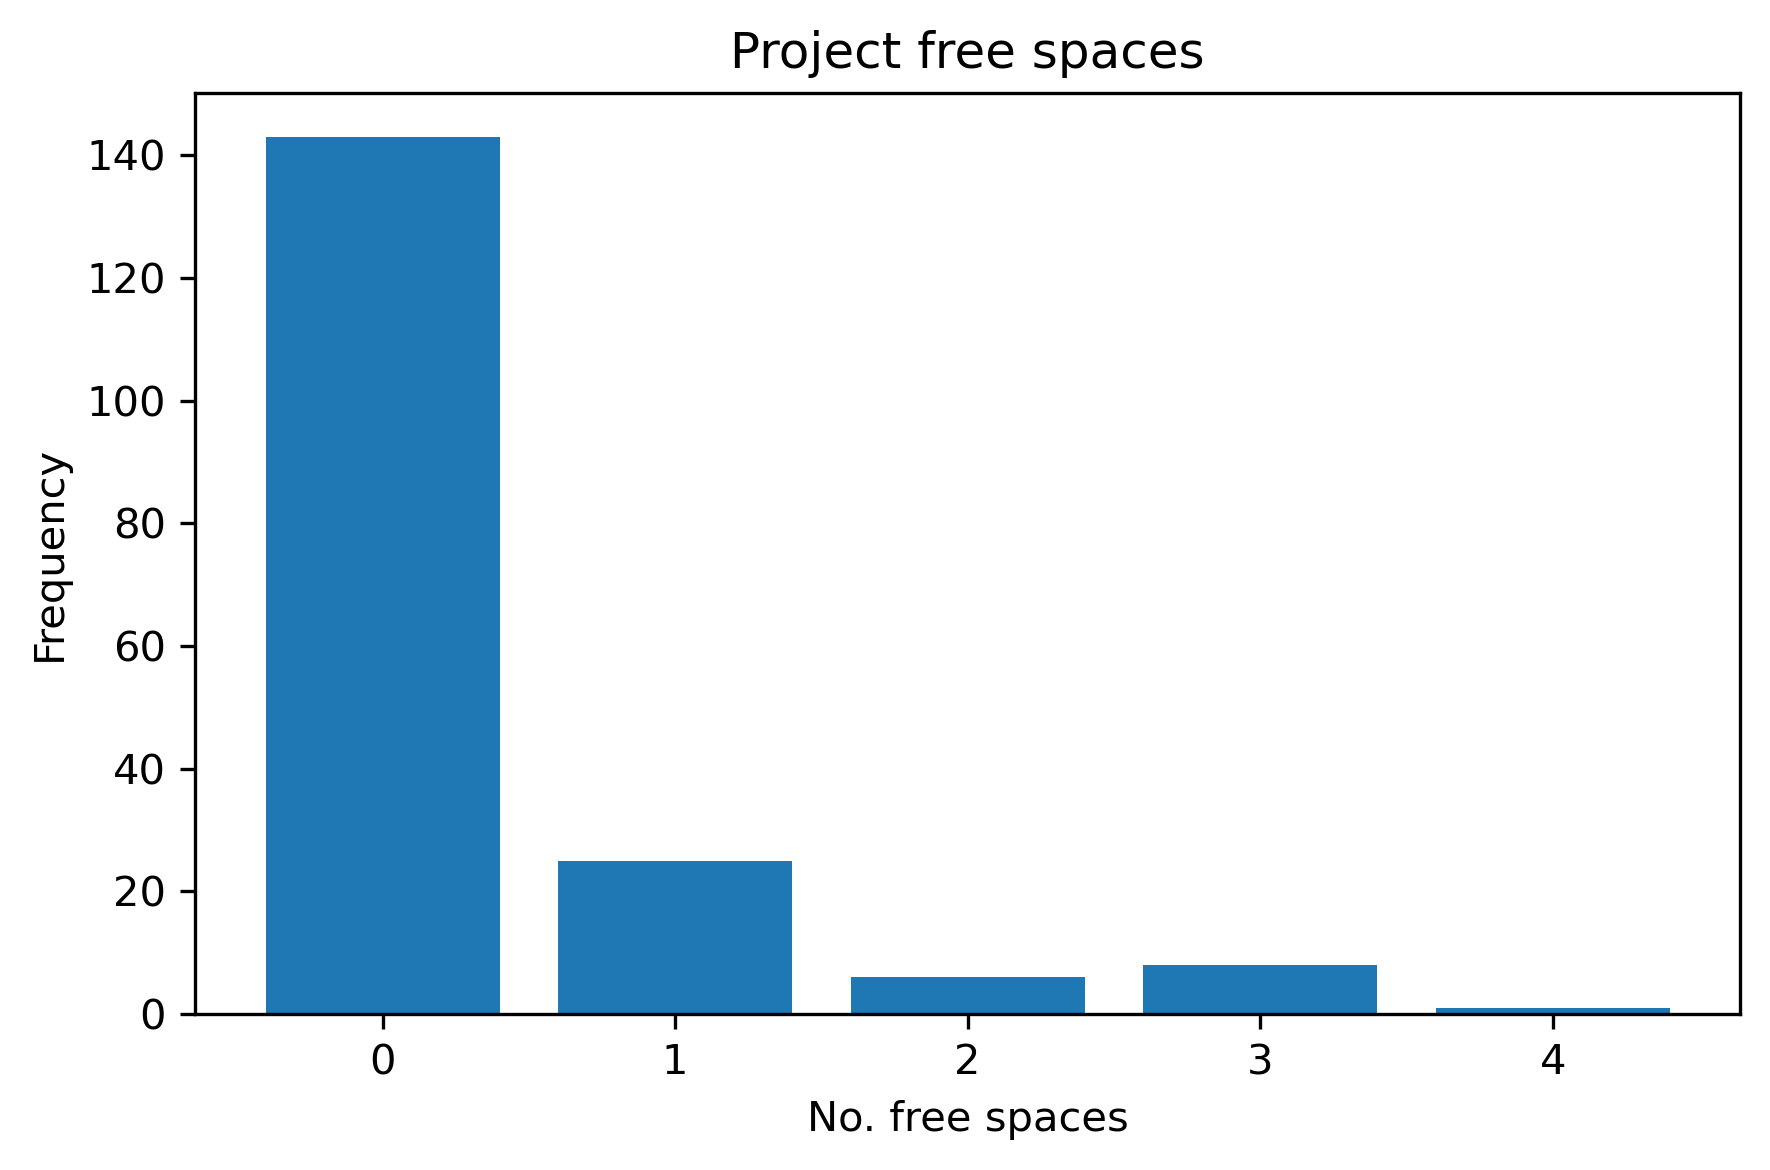

In [20]:
_, ax = plt.subplots(dpi=300)

data = Counter(project_free_spaces.values())
ax.bar(data.keys(), data.values())

ax.set(
    xlabel="No. free spaces",
    ylabel="Frequency",
    xticks=range(max(data.keys()) + 1),
    title="Project free spaces",
)

plt.tight_layout()
plt.savefig("img/project_free_spaces.pdf", transparent=True)

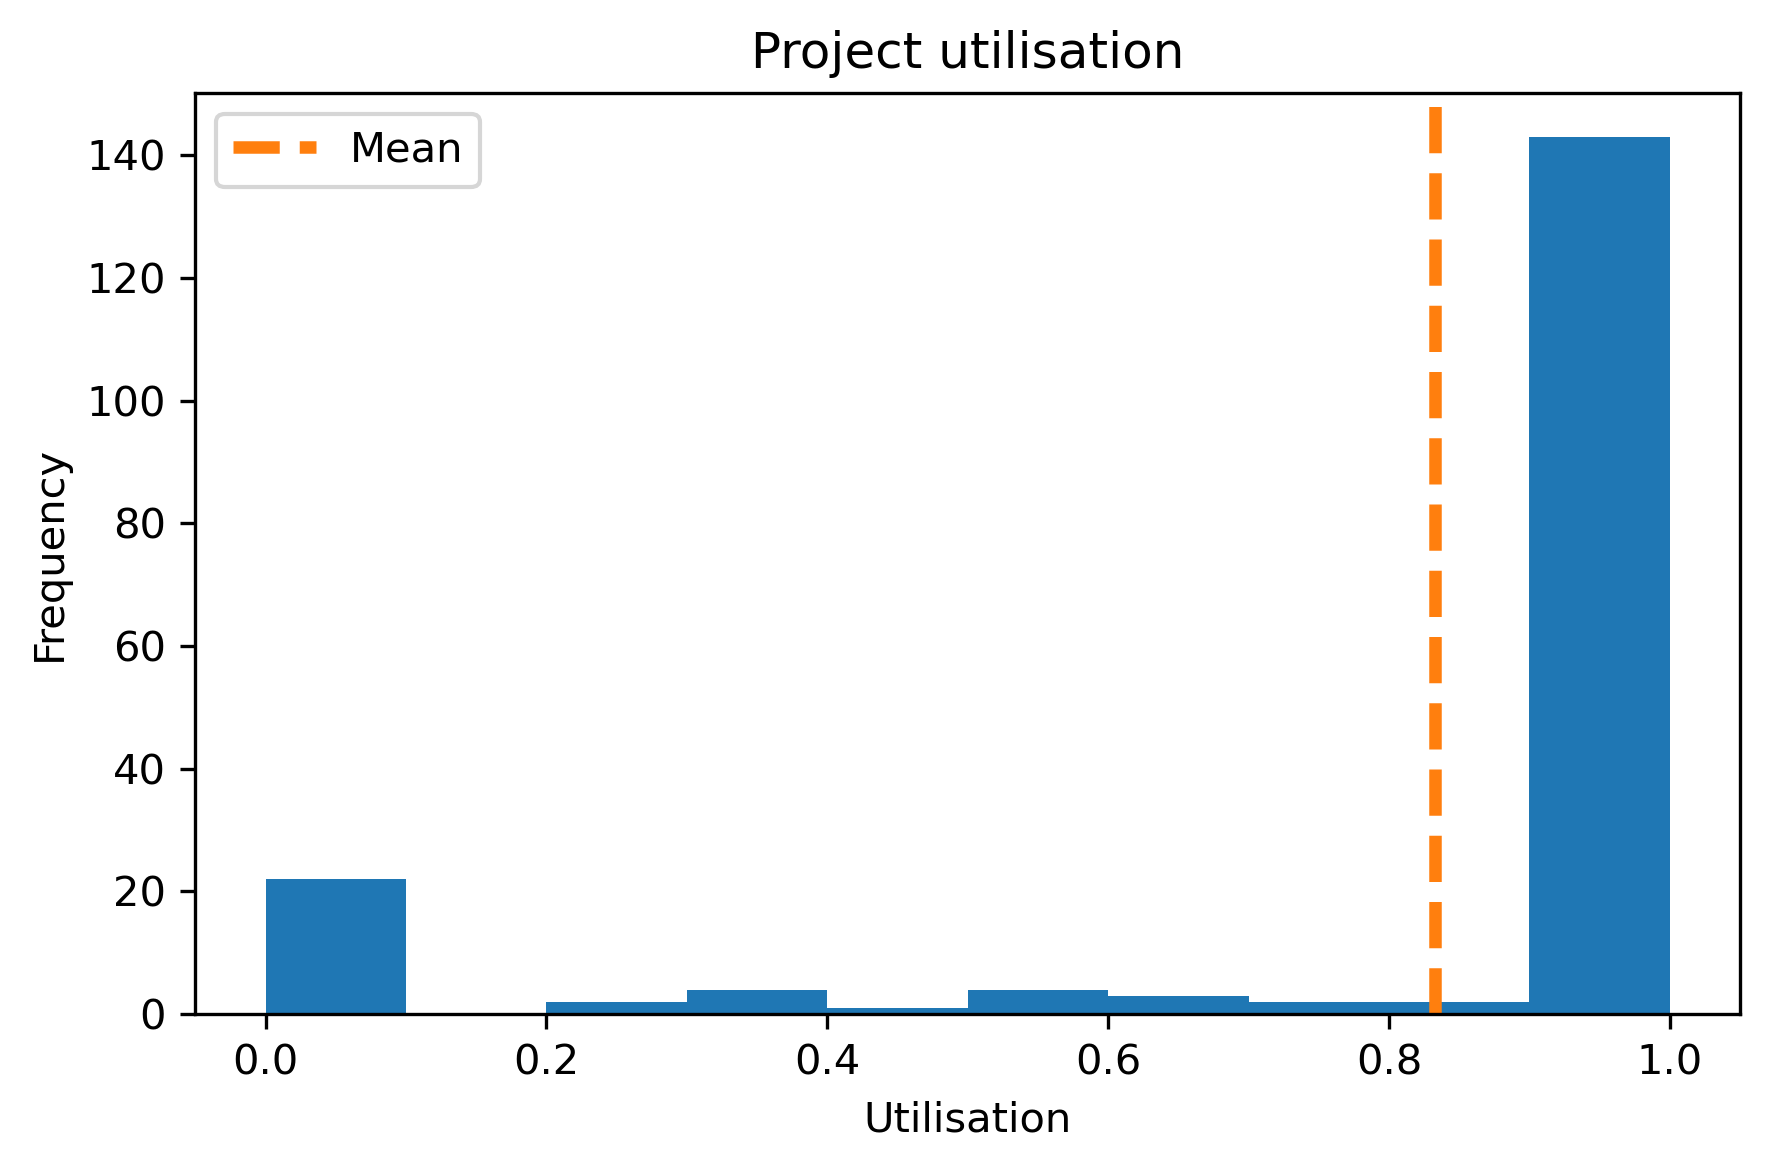

In [21]:
_, ax = plt.subplots(dpi=300)

values = list(project_utilisation.values())
ax.hist(values)

ylims = ax.get_ylim()
ax.vlines(
    np.mean(values), *ylims, "tab:orange", linestyle="dashed", label="Mean", lw=3
)

ax.set(
    ylim=ylims,
    xlabel="Utilisation",
    ylabel="Frequency",
    title="Project utilisation",
)

ax.legend()

plt.tight_layout()
plt.savefig("img/project_utilisation.pdf", transparent=True)

In [22]:
project_df = pd.concat(
    (pd.Series(project_free_spaces), pd.Series(project_utilisation)), axis=1
)
project_df.columns = ["free_spaces", "utilisation"]
project_df.describe().iloc[1:, :]

,free_spaces,utilisation
mean,0.355191,0.832605
std,0.791134,0.344988
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,4.000000,1.000000


## student ranking

In [23]:
invert_matching = {}
matching_rank = []
for project, students_ in game.matching.items():
    for student in students_:
        invert_matching[student.name] = project.name
        matching_rank.append(student._pref_names.index(project.name) + 1)

In [24]:
df_matching = pd.DataFrame(
    {
        "Student Number": list(invert_matching.keys()),
        "Project Code": list(invert_matching.values()),
        "Preference": matching_rank,
    }
)

order = students.set_index("Student Number").index
df_matching = df_matching.set_index("Student Number").reindex(order).reset_index()

df_matching["Rank"] = students["Ranking"]

unassigned_students = df_matching[df_matching["Preference"].isnull()]

assigned_students = df_matching[df_matching["Preference"].notnull()]
assigned_students["Preference"] = assigned_students["Preference"].astype(int)

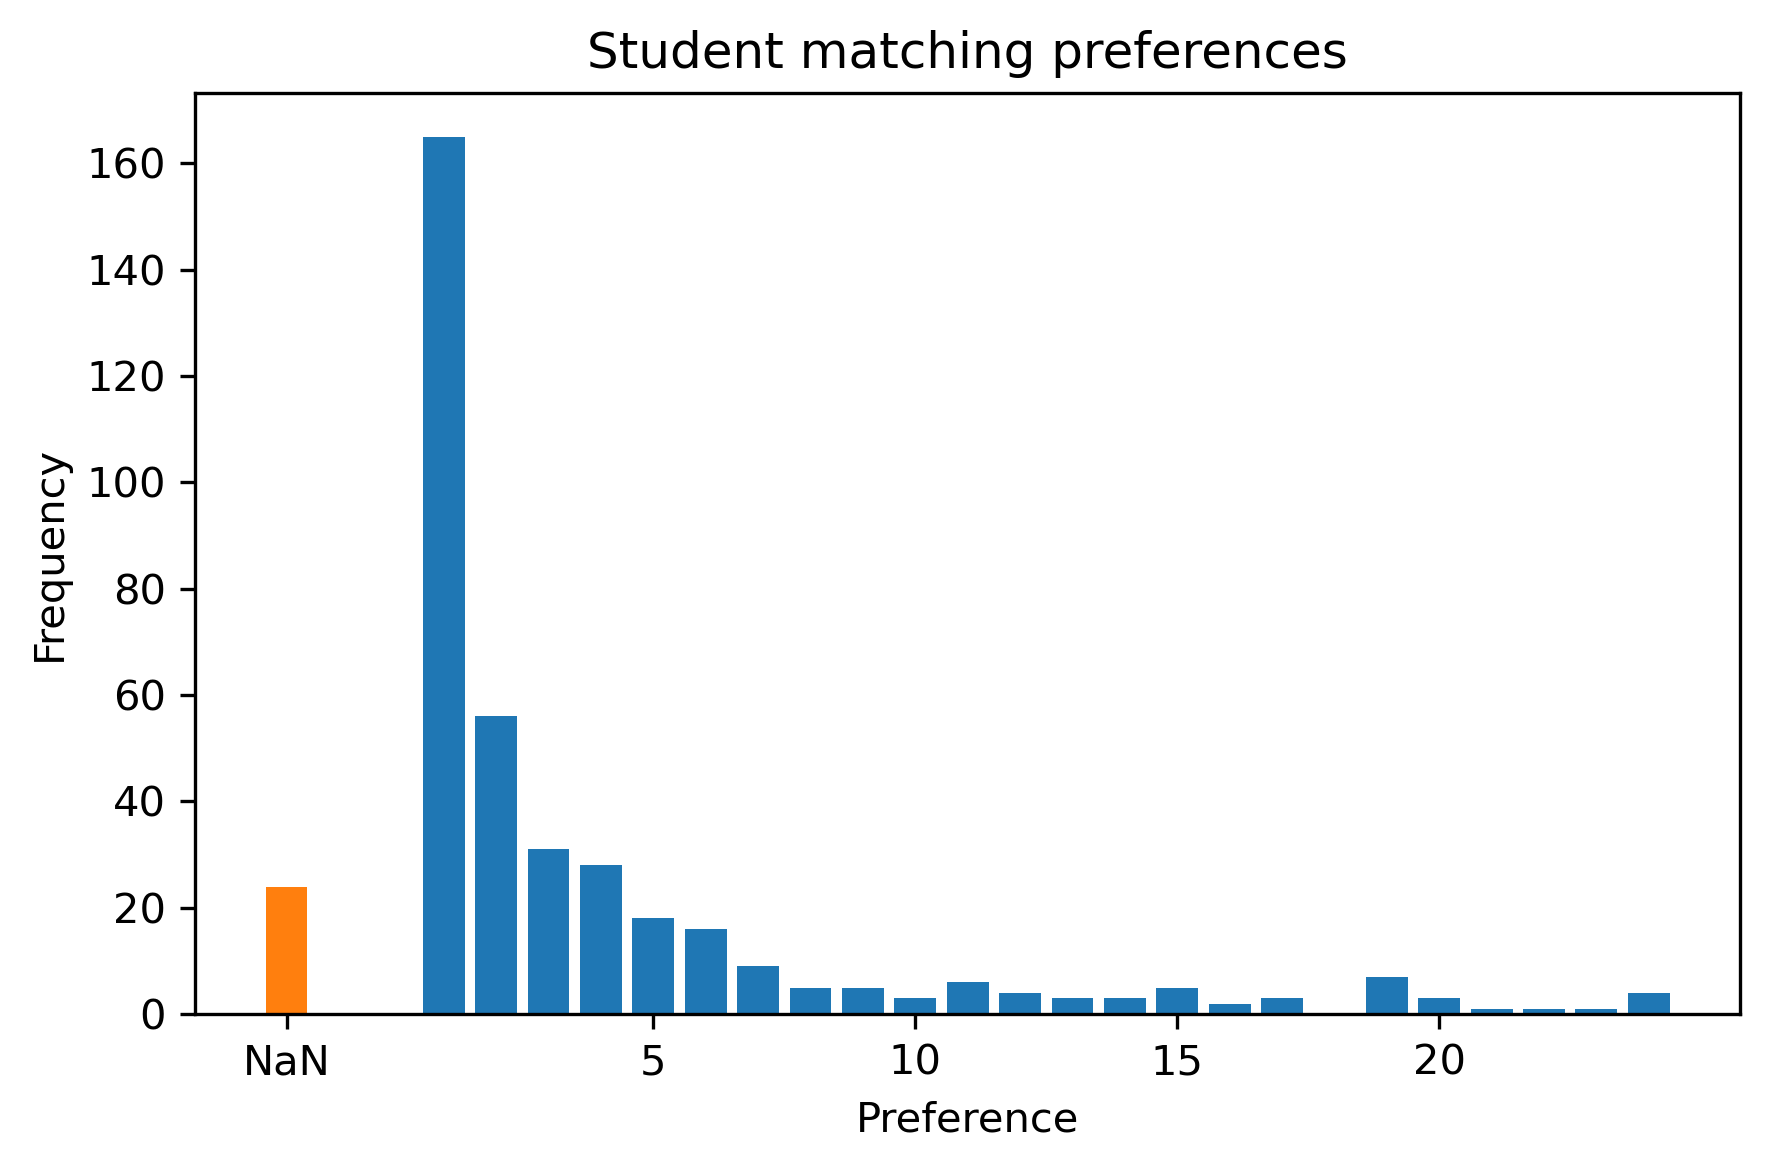

In [25]:
_, ax = plt.subplots(dpi=300)

values = Counter(assigned_students["Preference"])
ax.bar(values.keys(), values.values())
ax.bar(-2, len(unassigned_students))

ax.set(
    xticks=[-2] + list(range(5, 21, 5)),
    xticklabels=["NaN"] + list(range(5, 21, 5)),
    xlabel="Preference",
    ylabel="Frequency",
    title="Student matching preferences",
)

plt.tight_layout()
plt.savefig("img/rank_bar.pdf", transparent=True)

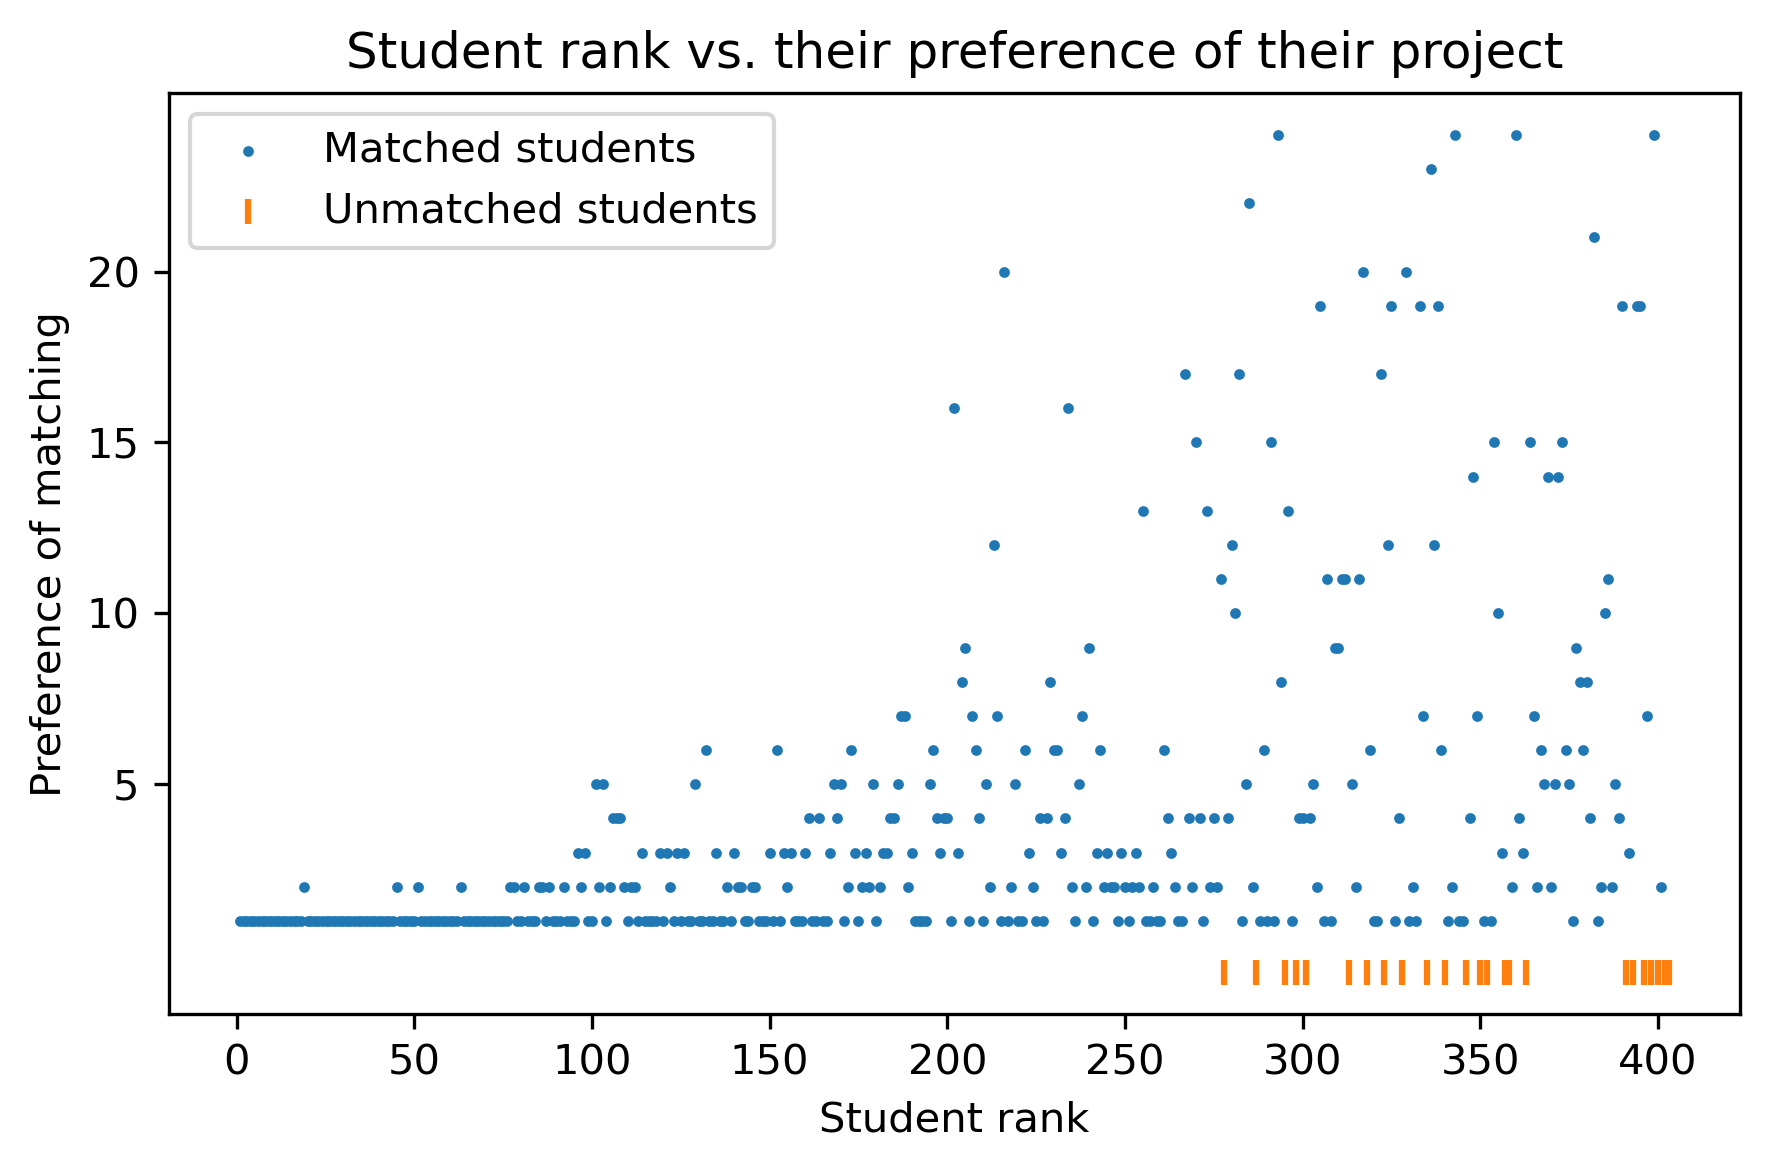

In [26]:
_, ax = plt.subplots(dpi=300)

ax.scatter(
    assigned_students["Rank"],
    assigned_students["Preference"],
    marker=".",
    s=10,
    label="Matched students",
)

ax.scatter(
    unassigned_students["Rank"],
    [-0.5] * len(unassigned_students),
    marker="|",
    label="Unmatched students",
)

ax.set(
    yticks=range(5, 21, 5),
    xlabel="Student rank",
    ylabel="Preference of matching",
    title="Student rank vs. their preference of their project",
)

ax.legend()

plt.tight_layout()
plt.savefig("img/rank_scatter.pdf", transparent=True)

## remaining spaces

In [27]:
project_with_space_names = [
    project.name
    for project in game.projects
    if len(project.matching) < project.capacity
] + list(unranked_projects)

supervisor_with_space_names = [
    supervisor.name
    for supervisor in game.supervisors
    if len(supervisor.matching) < supervisor.capacity
] + list(unranked_supervisors)

In [28]:
def get_number_of_matches(name, party, game):

    for player in vars(game)[party]:
        if player.name == name:
            return len(player.matching)

    return 0


def get_capacity(data, party, name):

    if party == "project":
        name_column = "Project Code"
        capacity_column = "Capacity"
    else:
        name_column = "Name"
        capacity_column = "Maximum Allocation"

    return data[data[name_column] == name][capacity_column].iloc[0]

In [29]:
projects_with_space = projects[
    (projects["Project Code"].isin(project_with_space_names))
    & (projects["Staff Name"].isin(supervisor_with_space_names))
]

projects_with_space["Supervisor Capacity"] = projects_with_space[
    "Staff Name"
].apply(lambda x: get_capacity(supervisors, "supervisor", x))

projects_with_space["No. Project Matches"] = projects_with_space["Project Code"].apply(
    lambda x: get_number_of_matches(x, "projects", game)
)

projects_with_space["No. Supervisor Matches"] = projects_with_space[
    "Staff Name"
].apply(lambda x: get_number_of_matches(x, "supervisors", game))

projects_with_space["No. Project Spaces"] = (
    projects_with_space["Capacity"] - projects_with_space["No. Project Matches"]
)

projects_with_space["No. Supervisor Spaces"] = (
    projects_with_space["Supervisor Capacity"] 
    - projects_with_space["No. Supervisor Matches"]
)

In [30]:
projects_with_space.to_csv("data/project_spaces.csv", index=False)
projects_with_space = projects_with_space.set_index(
    ["Staff Name", "Project Code"]
).sort_index()

In [31]:
unassigned_student_preferences = students.iloc[unassigned_students.index, :]

assigned_students.to_csv("data/assigned.csv", index=False)
unassigned_student_preferences.to_csv("data/unassigned.csv", index=False)

unassigned_student_preferences

,Student Number,Ranking,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
277,1887837,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,1889031,287,HMSLT1,KR1LT2,HMSLT3,HMSLT2,JM1LT1,ADWLT2,HEMLT1,ADWLT1,...,FS1LT2,BL1LT1,JLHLT1,OVGLT1,JVGLT3,JVGLT2,KASLT1,VC1LT2,YS1LT1,VC1LT4
294,1806280,295,KR1LT1,KR1LT2,HMSLT1,HMSLT2,EB1LT1,HMSLT3,EB1PD1,CEHLT1,...,DJMPD1,JLHLT1,JRRLT1,JVGPD1,JVGLT1,JVGLT3,JVGLT2,HEMLT2,HEMLT1,TCDLT1
297,1888077,298,GM1LT1,TCDLT1,KLTLT1,SKHLT2,TJHPL1,DP2LT1,ADWLT4,EY1LT1,...,JLHLT1,RJ1PL1,ADWLT3,MJLPD2,DJMLT2,CEHLT1,VC1LT1,RB1LT3,IM1LT1,PB1PD1
300,1707355,301,HMSLT1,EB1PD1,CEHLT1,KR1LT1,EB1LT1,JLHLT1,EY1LT1,SMRPE1,...,IMDLT1,THJLT1,KABLT1,TCDLT1,BL1LT1,HEMLT2,JVGLT3,SGSLT3,SGSLT1,HEJLT1
312,1888160,313,SKHLT2,SMRPE1,EY1LT1,JLHLT1,DR1LT1,CEHLT1,SGSLT3,KR1LT1,...,OVGLT1,DJMLT3,DP2LT1,JLHLT4,GM1LT1,JVGLT1,HMSLT2,DPRLT1,SLWLT1,HEMLT2
317,1819942,318,YS1PD1,HEMLT1,EB1PD1,EB1LT1,DR1LT1,SMRLT1,DJMPD1,HEMLT2,...,CEHPL1,HQ1PL1,JRRPL1,DPRLT1,EY1LT1,TJHPL1,JVGLT3,KASLT1,DP2LT1,HQ1LT1
322,1888154,323,HEJLT1,HEMLT2,IM1LT1,TCDLT1,HMSLT1,DR1LT1,HMSLT3,DJMLT3,...,PB1PL1,MJSPD1,CH1PB1,DJMLT1,DJMLT2,HEJLT2,TP1PD1,CH1PD1,DP1PB1,CH1LT1
327,1835566,328,EY1LT1,SMRLT1,SKHLT1,TJHPL1,BL1LT1,DP1PB1,JVGPD1,SKHLT2,...,NAKPB2,EB1PD1,EB1LT1,JLHLT1,SMRPE1,HMSLT2,GESLT2,DR1LT1,KABLT1,CH1LT1
334,1823739,335,HMSLT2,HMSLT1,DP2LT1,FS1LT2,DR1LT1,HMSLT3,EY1LT1,JLHLT1,...,SLWLT1,JRRLT1,SMRLT1,GM1LT1,ADWLT3,ADWLT2,TCDLT1,SGSLT1,SGSLT3,ADWLT2


In [32]:
(
    len(unassigned_students),
    projects_with_space["No. Project Spaces"].sum(),
    projects_with_space["No. Supervisor Spaces"].sum(),
)

(24, 32, 55)

In [33]:
(
    len(game.students),
    sum(proj.capacity for proj in game.projects),
    sum(sup.capacity for sup in game.supervisors),
)

(400, 444, 410)

In [34]:
assigned_students

,Student Number,Project Code,Preference,Rank
0,1803141,OMPPL1,1,1
1,1704686,ARJPL1,1,2
2,1721204,DP1PB1,1,3
3,1804809,HMSLT1,1,4
4,1706178,IM1LT1,1,5
...,...,...,...,...
393,1769211,VG1PB1,19,394
394,1709197,NF1PB1,19,395
396,1634571,SM1PB3,7,397
398,1770210,JL1PD1,24,399
